# stage 1

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# BN (pgmpy)
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

sns.set(style="whitegrid", rc={"figure.figsize":(8,5)})

def type1_type2(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    t1 = fp/(fp+tn+1e-9)  # False Positive rate
    t2 = fn/(fn+tp+1e-9)  # False Negative rate
    return t1, t2, (tn, fp, fn, tp)

def eval_at_threshold(y_true, y_proba, thr):
    y_pred = (np.array(y_proba) >= thr).astype(int)
    ca  = accuracy_score(y_true, y_pred)
    pr  = precision_score(y_true, y_pred, zero_division=0)
    re  = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    t1, t2, cm = type1_type2(y_true, y_pred)
    return {"Threshold":thr, "CA":ca, "Precision":pr, "Recall":re, "F1":f1, "AUC":auc,
            "Type I Error":t1, "Type II Error":t2, "TN":cm[0], "FP":cm[1], "FN":cm[2], "TP":cm[3]}


In [120]:
# 1.1 Lo
df = pd.read_csv("/Users/mano/churn_project/churn.csv")
df.head(3)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [121]:
# 1.2 Light clean (drop pure IDs & high-cardinality strings)
for col in ["RowNumber","CustomerId","Surname"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# Duplicates & missing
print("Duplicates:", df.duplicated().sum())
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False))


Duplicates: 0
Missing values per column:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


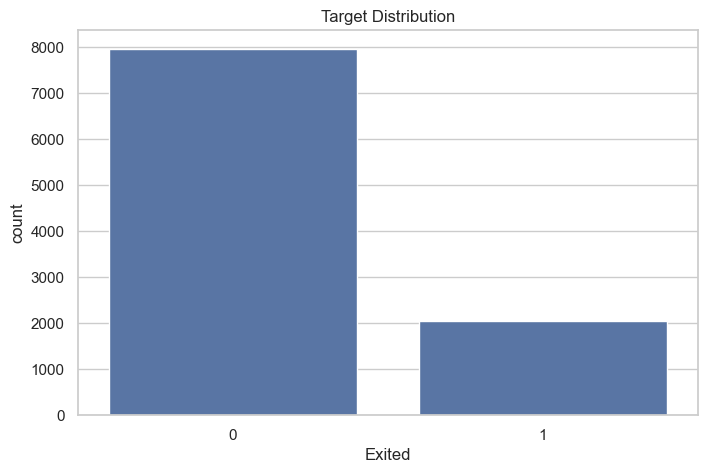

Exited
0    79.63
1    20.37
Name: Percent, dtype: float64


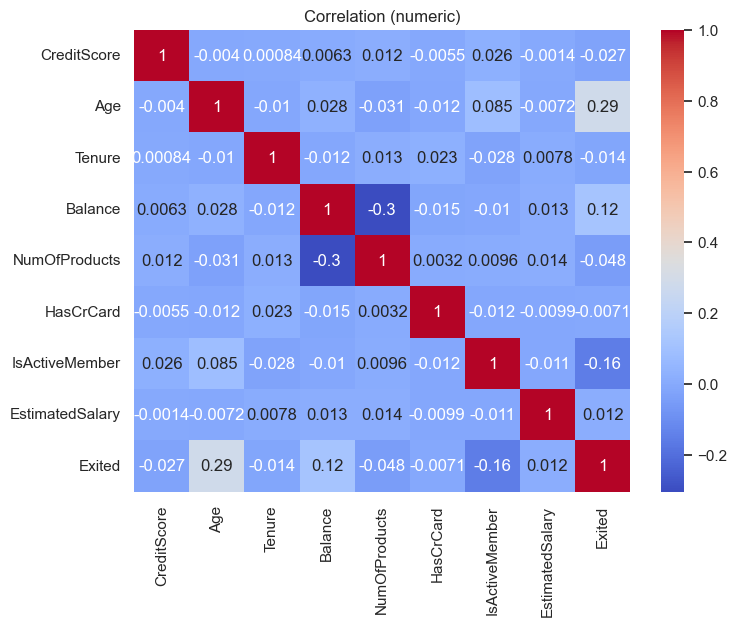

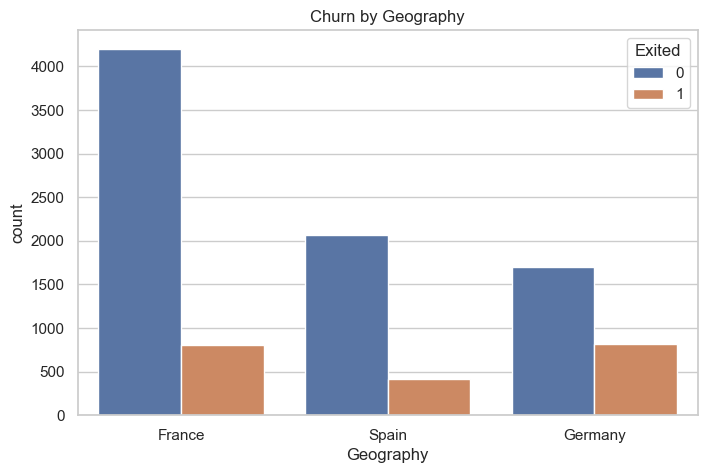

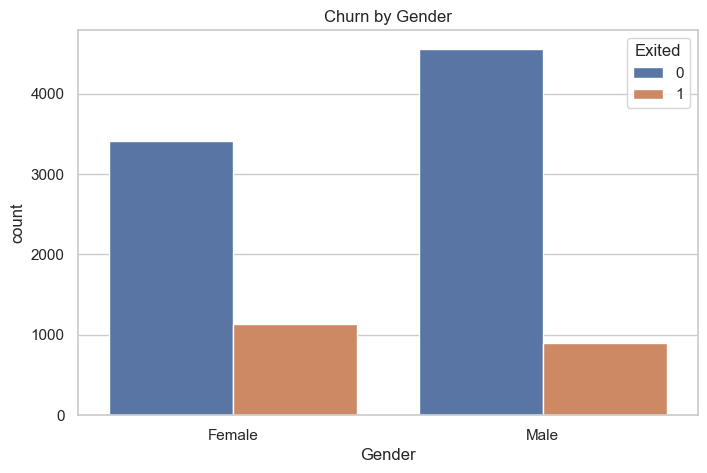

AgeBand
<30      0.075203
31-40    0.120872
41-50    0.339655
51-60    0.562108
60+      0.247845
Name: ChurnRate_by_AgeBand, dtype: float64


/var/folders/wp/wlm97fn11qx3zn4bf8cysn440000gn/T/ipykernel_15037/552702038.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("AgeBand")["Exited"].mean().rename("ChurnRate_by_AgeBand"))


In [122]:
# 1.3 EDA
sns.countplot(x="Exited", data=df); plt.title("Target Distribution"); plt.show()
print((df["Exited"].value_counts(normalize=True)*100).rename("Percent"))

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=True)
plt.title("Correlation (numeric)"); plt.show()

if "Geography" in df.columns:
    sns.countplot(x="Geography", hue="Exited", data=df); plt.title("Churn by Geography"); plt.show()
if "Gender" in df.columns:
    sns.countplot(x="Gender", hue="Exited", data=df); plt.title("Churn by Gender"); plt.show()

df["AgeBand"] = pd.cut(df["Age"], [0,30,40,50,60,200], labels=["<30","31-40","41-50","51-60","60+"])
print(df.groupby("AgeBand")["Exited"].mean().rename("ChurnRate_by_AgeBand"))


In [123]:
# 1.4 Preprocessor for ML models (RF/LR)
target = "Exited"
y = df[target]
X = df.drop(columns=[target])

cat_cols = [c for c in X.columns if X[c].dtype=="object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])


# stage 2

BN-ready dataset:
   RowNumber  CustomerId   Surname CreditScore Geography  Gender Age Tenure  \
0          1    15634602  Hargrave           1    France  Female   3      1   
1          2    15647311      Hill           1     Spain  Female   3      0   
2          3    15619304      Onio           0    France  Female   3      4   
3          4    15701354      Boni           3    France  Female   2      0   
4          5    15737888  Mitchell           4     Spain  Female   3      1   

  Balance  NumOfProducts HasCrCard IsActiveMember EstimatedSalary Exited  
0       0              1         1              1               2      1  
1       1              1         0              1               2      0  
2       3              3         1              0               2      1  
3       0              2         0              0               2      0  
4       2              1         1              1               1      0  


/Users/mano/churn_project/churn_bn_env/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges in BN: [('Geography', 'Balance'), ('Age', 'IsActiveMember'), ('NumOfProducts', 'Balance'), ('Exited', 'NumOfProducts'), ('Exited', 'Age'), ('Exited', 'Geography'), ('Exited', 'IsActiveMember'), ('Exited', 'Gender'), ('Exited', 'Balance')]


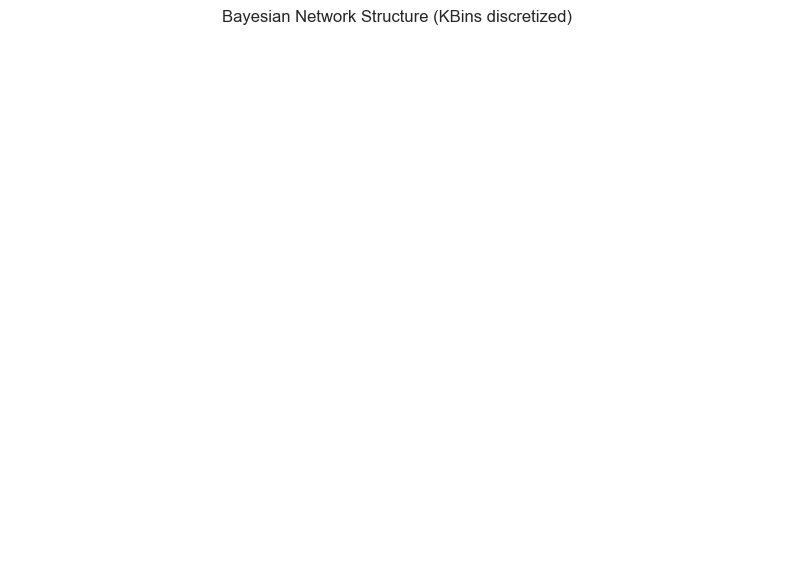

In [124]:
# Stage 2: Bayesian Network with discretization using KBinsDiscretizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

# ---- Load dataset again (if not already loaded)
df = pd.read_csv("/Users/mano/churn_project/churn.csv")

# Target
y = df["Exited"]

# Copy for BN
bn_df = df.copy()

# ---- Select numeric columns to discretize
num_cols = ["CreditScore","Age","Balance","EstimatedSalary","Tenure"]

# Apply KBinsDiscretizer
disc = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
bn_df[num_cols] = disc.fit_transform(bn_df[num_cols])

# Convert them to categorical string labels (important for pgmpy)
for col in num_cols:
    bn_df[col] = bn_df[col].astype(int).astype(str)

# Keep categorical features as strings
cat_cols = ["Geography","Gender","HasCrCard","IsActiveMember","Exited"]
for col in cat_cols:
    bn_df[col] = bn_df[col].astype(str)

print("BN-ready dataset:")
print(bn_df.head())

# ---- Step 2.1: Learn structure
hc = HillClimbSearch(bn_df)
best_model = hc.estimate(scoring_method=BicScore(bn_df))

bn = BayesianNetwork(best_model.edges())
print("Edges in BN:", bn.edges())

# ---- Step 2.2: Parameter learning
bn.fit(bn_df, estimator=MaximumLikelihoodEstimator)

# ---- Step 2.3: Visualize structure safely (without StopIteration bug)

plt.figure(figsize=(10,7))

# Use spring layout
pos = nx.spring_layout(bn, seed=42)

# Draw nodes
nx.draw_networkx_nodes(bn, pos, node_size=3000, node_color="lightblue")

# Draw edges WITHOUT arrow patches (avoids StopIteration bug)
nx.draw_networkx_edges(bn, pos, edge_color="gray", width=2, arrows=False)

# Add labels
nx.draw_networkx_labels(bn, pos, font_size=9, font_weight="bold")

plt.title("Bayesian Network Structure (KBins discretized)")
plt.axis("off")
plt.show()



In [125]:
# ---- Stage 2: Bayesian Network ----
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from imblearn.over_sampling import SMOTE
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# ---- Step 2.1: Drop unwanted columns
df_bn = df.drop(columns=["RowNumber", "CustomerId", "Surname"])  # Surname removed

# ---- Step 2.2: Discretize numerical features
disc = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
num_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary", "Tenure"]

df_bn[num_cols] = disc.fit_transform(df_bn[num_cols])
df_bn[num_cols] = df_bn[num_cols].astype(str)  # convert bins to strings

# ---- Step 2.3: Encode categorical features (Geography, Gender)
cat_cols = ["Geography", "Gender"]
le = LabelEncoder()
for col in cat_cols:
    df_bn[col] = le.fit_transform(df_bn[col])

# ---- Step 2.4: Balance dataset with SMOTE
X = df_bn.drop("Exited", axis=1)
y = df_bn["Exited"]

sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

bn_df = pd.DataFrame(X_bal, columns=X.columns)
bn_df["Exited"] = y_bal

print("Balanced class distribution:\n", bn_df["Exited"].value_counts())

# ---- Step 2.5: Learn BN structure
hc = HillClimbSearch(bn_df)
best_model = hc.estimate(scoring_method=BicScore(bn_df))

print("BN edges:", list(best_model.edges()))

# ---- Step 2.6: Parameter learning
bn = BayesianNetwork(best_model.edges())
bn.fit(bn_df, estimator=MaximumLikelihoodEstimator)

# ---- Step 2.7: Inference example
infer = VariableElimination(bn)
# pick a sample
sample = bn_df.sample(1, random_state=42).iloc[0]

# keep only the features used in the BN (columns of bn_df except 'Exited')
evidence = sample.drop("Exited").to_dict()

# double-check valid nodes
print("BN nodes:", bn.nodes())
print("Evidence keys:", list(evidence.keys()))

# filter evidence to only valid nodes
evidence = {k: v for k, v in evidence.items() if k in bn.nodes()}

# query probability
q = infer.query(variables=["Exited"], evidence=evidence)

print("Evidence:", evidence)
print("P(Exited=1):", float(q.values[1]))



Balanced class distribution:
 Exited
1    7963
0    7963
Name: count, dtype: int64


/Users/mano/churn_project/churn_bn_env/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(


  0%|          | 0/1000000 [00:00<?, ?it/s]

BN edges: [('IsActiveMember', 'HasCrCard'), ('Exited', 'NumOfProducts'), ('Exited', 'IsActiveMember'), ('Exited', 'Gender'), ('Exited', 'Geography'), ('Exited', 'HasCrCard')]
BN nodes: ['IsActiveMember', 'HasCrCard', 'Exited', 'NumOfProducts', 'Gender', 'Geography']
Evidence keys: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Evidence: {'Geography': 0, 'Gender': 0, 'NumOfProducts': 2, 'HasCrCard': 0, 'IsActiveMember': 1}
P(Exited=1): 0.17789756341945176


In [126]:
# Ensure evidence only includes variables in the BN
bn_nodes = set(bn.nodes())
y_true, y_proba = [], []

for _, row in bn_df.iterrows():
    evidence = {k: v for k, v in row.drop("Exited").to_dict().items() if k in bn_nodes}
    q = infer.query(variables=["Exited"], evidence=evidence)
    y_true.append(row["Exited"])
    y_proba.append(q.values[1])  # probability of Exited=1

# Threshold
thr = 0.5
y_pred = (np.array(y_proba) >= thr).astype(int)

# Metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, y_proba)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
type1 = fp / (fp + tn + 1e-9)
type2 = fn / (fn + tp + 1e-9)

print("BN Evaluation Results")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Type I Error : {type1:.4f}")
print(f"Type II Error: {type2:.4f}")
print("Confusion Matrix:", tn, fp, fn, tp)


BN Evaluation Results
Accuracy     : 0.7500
Precision    : 0.7412
Recall       : 0.7682
F1 Score     : 0.7544
AUC          : 0.8277
Type I Error : 0.2682
Type II Error: 0.2318
Confusion Matrix: 5827 2136 1846 6117


In [127]:
# --- Restrict to BN nodes
bn_nodes = set(bn.nodes())
y_true, y_proba = [], []

for _, row in bn_df.iterrows():
    evidence = {k: v for k, v in row.drop("Exited").to_dict().items() if k in bn_nodes}
    q = infer.query(variables=["Exited"], evidence=evidence)
    y_true.append(row["Exited"])
    y_proba.append(q.values[1])  # probability of Exited=1

y_true = np.array(y_true)
y_proba = np.array(y_proba)

# --- Try multiple thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for thr in thresholds:
    y_pred = (y_proba >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    type1 = fp / (fp + tn + 1e-9)
    type2 = fn / (fn + tp + 1e-9)

    results.append({
        "Threshold": thr,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Type I Error": type1,
        "Type II Error": type2
    })

# --- Best threshold
results_df = pd.DataFrame(results)
best_row = results_df.sort_values(by="F1", ascending=False).iloc[0]

print("Best BN Results with Balanced Data")
print(best_row)

# Show all thresholds
display(results_df)


Best BN Results with Balanced Data
Threshold        0.400000
Accuracy         0.745259
Precision        0.706492
Recall           0.839131
F1               0.767120
AUC              0.827694
Type I Error     0.348612
Type II Error    0.160869
Name: 3, dtype: float64


,Threshold,Accuracy,Precision,Recall,F1,AUC,Type I Error,Type II Error
0,0.1,0.569886,0.537984,0.989828,0.697090,0.827694,0.850057,0.010172
1,0.2,0.674369,0.612877,0.946754,0.744078,0.827694,0.598016,0.053246
2,0.3,0.710787,0.650309,0.911968,0.759226,0.827694,0.490393,0.088032
3,0.4,0.745259,0.706492,0.839131,0.767120,0.827694,0.348612,0.160869
4,0.5,0.749969,0.741185,0.768178,0.754440,0.827694,0.268241,0.231822
5,0.6,0.737724,0.803852,0.628909,0.705700,0.827694,0.153460,0.371091
6,0.7,0.727804,0.829220,0.573779,0.678245,0.827694,0.118172,0.426221
7,0.8,0.612206,0.908177,0.249655,0.391647,0.827694,0.025242,0.750345
8,0.9,0.567311,0.946667,0.142660,0.247954,0.827694,0.008037,0.857340


In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_bn(infer, df, target="Exited", thresholds=np.arange(0.1,1.0,0.1)):
    y_true, y_proba = [], []

    for _, row in df.iterrows():
        evidence = row.drop(target).to_dict()
        q = infer.query(variables=[target], evidence=evidence)
        y_true.append(row[target])
        y_proba.append(q.values[1])  # probability target=1

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    best = None
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_proba)
        cm = confusion_matrix(y_true, y_pred)

        type1 = cm[0,1] / (cm[0,0]+cm[0,1]) if (cm[0,0]+cm[0,1]) > 0 else np.nan
        type2 = cm[1,0] / (cm[1,0]+cm[1,1]) if (cm[1,0]+cm[1,1]) > 0 else np.nan

        metrics = {
            "CA": acc, "Precision": prec, "Recall": rec, "F1": f1,
            "AUC": auc, "Type I Error": type1, "Type II Error": type2, "Threshold": t
        }
        if best is None or f1 > best["F1"]:
            best = metrics

    return best


In [129]:
bn_df = bn_df.drop(columns=["CreditScore", "Age", "Balance", "EstimatedSalary", "Tenure"])


In [130]:
best_metrics_bn = evaluate_bn(infer, bn_df, target="Exited")
print("Best BN Results:", best_metrics_bn)


Best BN Results: {'CA': 0.7452593243752355, 'Precision': 0.7064918587439205, 'Recall': 0.8391309807861359, 'F1': 0.7671201423569255, 'AUC': 0.8276940115899908, 'Type I Error': 0.34861233203566494, 'Type II Error': 0.16086901921386412, 'Threshold': 0.4}


Best BN Results with Balanced Data:
Threshold        0.400000
Accuracy         0.745259
Precision        0.706492
Recall           0.839131
F1               0.767120
AUC              0.827694
Type I Error     0.348612
Type II Error    0.160869
Name: 3, dtype: float64


,Threshold,Accuracy,Precision,Recall,F1,AUC,Type I Error,Type II Error
0,0.1,0.569886,0.537984,0.989828,0.697090,0.827694,0.850057,0.010172
1,0.2,0.674369,0.612877,0.946754,0.744078,0.827694,0.598016,0.053246
2,0.3,0.710787,0.650309,0.911968,0.759226,0.827694,0.490393,0.088032
3,0.4,0.745259,0.706492,0.839131,0.767120,0.827694,0.348612,0.160869
4,0.5,0.749969,0.741185,0.768178,0.754440,0.827694,0.268241,0.231822
5,0.6,0.737724,0.803852,0.628909,0.705700,0.827694,0.153460,0.371091
6,0.7,0.727804,0.829220,0.573779,0.678245,0.827694,0.118172,0.426221
7,0.8,0.612206,0.908177,0.249655,0.391647,0.827694,0.025242,0.750345
8,0.9,0.567311,0.946667,0.142660,0.247954,0.827694,0.008037,0.857340


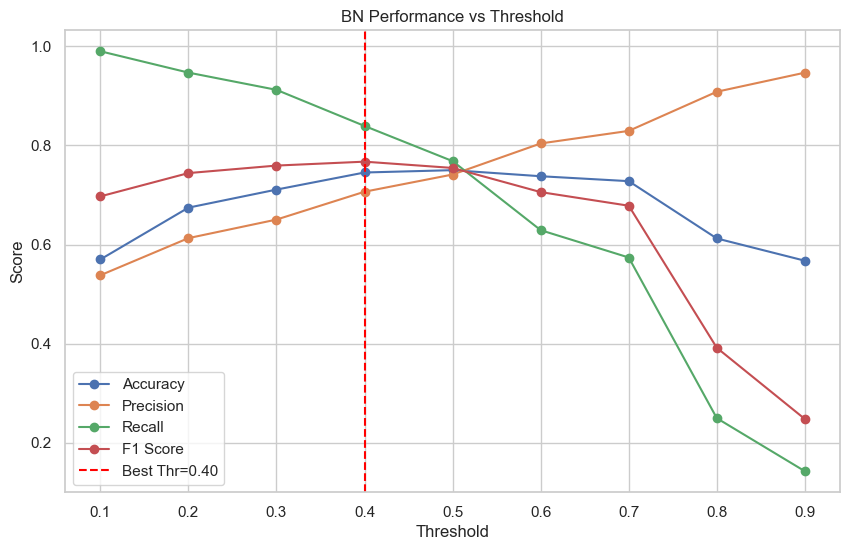

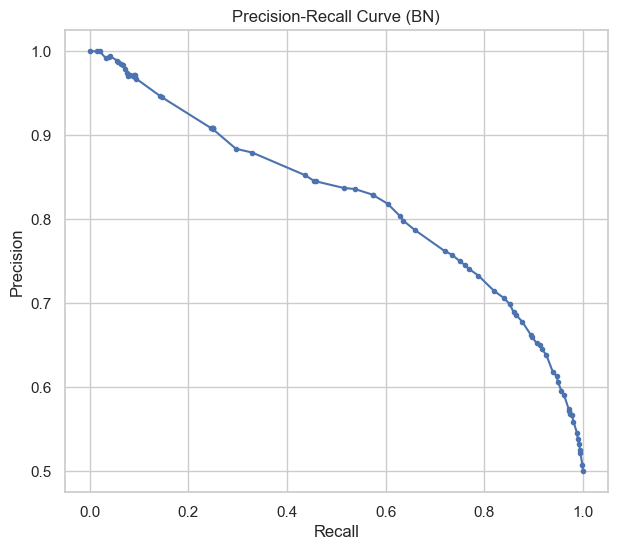

In [131]:
import matplotlib.pyplot as plt

# --- Restrict to BN nodes
bn_nodes = set(bn.nodes())
y_true, y_proba = [], []

for _, row in bn_df.iterrows():
    evidence = {k: v for k, v in row.drop("Exited").to_dict().items() if k in bn_nodes}
    q = infer.query(variables=["Exited"], evidence=evidence)
    y_true.append(row["Exited"])
    y_proba.append(q.values[1])  # probability of Exited=1

y_true = np.array(y_true)
y_proba = np.array(y_proba)

# --- Try multiple thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for thr in thresholds:
    y_pred = (y_proba >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    type1 = fp / (fp + tn + 1e-9)
    type2 = fn / (fn + tp + 1e-9)

    results.append({
        "Threshold": thr,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Type I Error": type1,
        "Type II Error": type2
    })

# --- Best threshold
results_df = pd.DataFrame(results)
best_row = results_df.sort_values(by="F1", ascending=False).iloc[0]

print("Best BN Results with Balanced Data:")
print(best_row)

# --- Show all results
display(results_df)

# --- Plot Accuracy, Precision, Recall, F1 vs Threshold
plt.figure(figsize=(10,6))
plt.plot(results_df["Threshold"], results_df["Accuracy"], marker="o", label="Accuracy")
plt.plot(results_df["Threshold"], results_df["Precision"], marker="o", label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], marker="o", label="Recall")
plt.plot(results_df["Threshold"], results_df["F1"], marker="o", label="F1 Score")

plt.axvline(best_row["Threshold"], color="red", linestyle="--", label=f"Best Thr={best_row['Threshold']:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("BN Performance vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thr_pr = precision_recall_curve(y_true, y_proba)

plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (BN)")
plt.grid(True)
plt.show()


# stage 3

In [132]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Drop obvious non-features
df_rf = df.drop(columns=["RowNumber","CustomerId","Surname"], errors="ignore").copy()

# Target & features
y = df_rf["Exited"].astype(int)
X = df_rf.drop(columns=["Exited"])

# Identify column types
categorical_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
numeric_cols     = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric    :", numeric_cols)
print("Class balance:\n", y.value_counts(normalize=True).rename({0:"% non-churn",1:"% churn"}))


Categorical: ['Geography', 'Gender']
Numeric    : ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Class balance:
 Exited
% non-churn    0.7963
% churn        0.2037
Name: proportion, dtype: float64


In [133]:
# Preprocess
preprocessor = ColumnTransformer([
    ("num", StandardScaler(with_mean=True, with_std=True), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
])

# Full pipeline: preprocess -> SMOTE -> RF
rf_pipe = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])


In [134]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# --- Pipeline with preprocessing
rf_pipe = Pipeline([
    ("preprocess", preprocessor),  # OneHot for categorical, passthrough for numeric
    ("rf", RandomForestClassifier(
        n_estimators=200, max_depth=8, random_state=42, class_weight="balanced"
    ))
])

# --- Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rows_rf = []
thr = 0.50  # change to 0.80 if you want higher precision/lower recall

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    model = rf_pipe.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:,1]
    pred  = (proba >= thr).astype(int)

    acc  = accuracy_score(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec  = recall_score(y_te, pred, zero_division=0)
    f1   = f1_score(y_te, pred, zero_division=0)
    auc  = roc_auc_score(y_te, proba)

    tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
    type1 = fp / (fp + tn + 1e-9)
    type2 = fn / (fn + tp + 1e-9)

    cv_rows_rf.append({
        "Fold": fold,
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc,
        "Type I Error": type1, "Type II Error": type2
    })

cv_df_rf = pd.DataFrame(cv_rows_rf)
summary_rf = cv_df_rf.mean(numeric_only=True).to_frame("Mean")
summary_rf["Std"] = cv_df_rf.std(numeric_only=True)

print("Random Forest - Per-fold metrics:\n", cv_df_rf.round(4))
print("\nRandom Forest - CV summary (mean ± std):\n", summary_rf.round(4))


Random Forest - Per-fold metrics:
    Fold  Accuracy  Precision  Recall      F1     AUC  Type I Error  \
0     1    0.8180     0.5421  0.6936  0.6086  0.8659        0.1501   
1     2    0.8195     0.5499  0.6348  0.5893  0.8442        0.1332   
2     3    0.8170     0.5404  0.6732  0.5996  0.8544        0.1463   
3     4    0.8200     0.5443  0.7101  0.6162  0.8620        0.1519   
4     5    0.8405     0.5902  0.7076  0.6436  0.8638        0.1255   

   Type II Error  
0         0.3064  
1         0.3652  
2         0.3268  
3         0.2899  
4         0.2924  

Random Forest - CV summary (mean ± std):
                  Mean     Std
Fold           3.0000  1.5811
Accuracy       0.8230  0.0099
Precision      0.5534  0.0209
Recall         0.6839  0.0311
F1             0.6115  0.0206
AUC            0.8581  0.0089
Type I Error   0.1414  0.0115
Type II Error  0.3161  0.0311


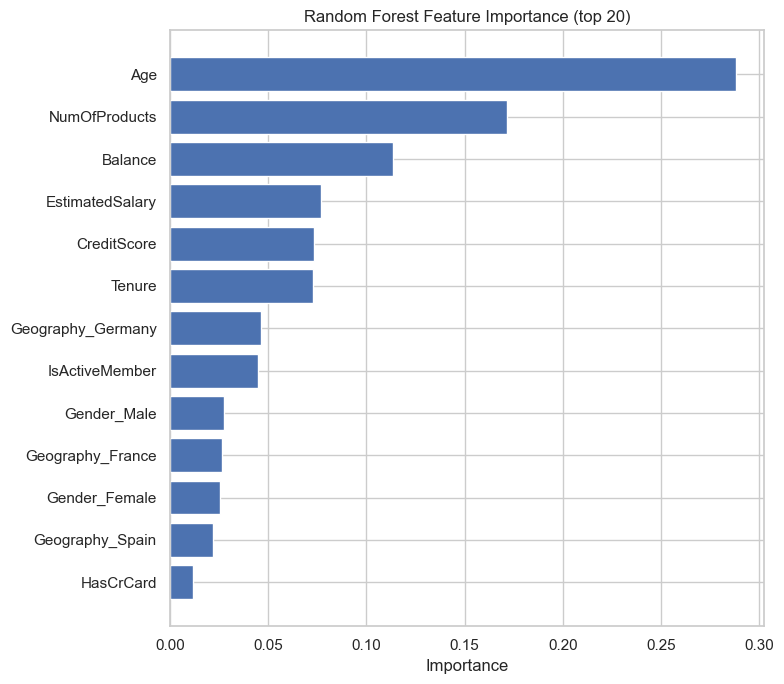

In [135]:
import matplotlib.pyplot as plt

topk = 20
plt.figure(figsize=(8, max(4, topk*0.35)))
plt.barh(fi.head(topk)["feature"][::-1], fi.head(topk)["importance"][::-1])
plt.title("Random Forest Feature Importance (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# stage 4

In [136]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
lr_pipe = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("lr", LogisticRegression(
        max_iter=500,
        solver="liblinear",   # good for sparse high-dim data
        class_weight=None,    # SMOTE balances already
        random_state=42
    ))
])


In [137]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
thr = 0.50   # threshold (tune if you want higher recall/precision)

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    model = lr_pipe.fit(X_tr, y_tr)
    proba = model.predict_proba(X_te)[:,1]
    pred  = (proba >= thr).astype(int)

    acc  = accuracy_score(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec  = recall_score(y_te, pred, zero_division=0)
    f1   = f1_score(y_te, pred, zero_division=0)
    auc  = roc_auc_score(y_te, proba)

    tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
    type1 = fp / (fp + tn + 1e-9)
    type2 = fn / (fn + tp + 1e-9)

    cv_rows.append({
        "Fold": fold,
        "Accuracy": acc, "Precision": prec, "Recall": rec,
        "F1": f1, "AUC": auc,
        "Type I Error": type1, "Type II Error": type2
    })

cv_df_lr = pd.DataFrame(cv_rows)
summary_lr = cv_df_lr.mean(numeric_only=True).to_frame("Mean")
summary_lr["Std"] = cv_df_lr.std(numeric_only=True)

print("Logistic Regression CV metrics per fold:\n", cv_df_lr.round(4))
print("\nSummary (mean ± std):\n", summary_lr.round(4))


Logistic Regression CV metrics per fold:
    Fold  Accuracy  Precision  Recall      F1     AUC  Type I Error  \
0     1    0.7270     0.4065  0.7353  0.5236  0.7859        0.2751   
1     2    0.7185     0.3888  0.6642  0.4905  0.7527        0.2676   
2     3    0.7065     0.3736  0.6536  0.4754  0.7515        0.2800   
3     4    0.7070     0.3830  0.7199  0.5000  0.7720        0.2963   
4     5    0.7230     0.3957  0.6855  0.5018  0.7824        0.2674   

   Type II Error  
0         0.2647  
1         0.3358  
2         0.3464  
3         0.2801  
4         0.3145  

Summary (mean ± std):
                  Mean     Std
Fold           3.0000  1.5811
Accuracy       0.7164  0.0093
Precision      0.3895  0.0125
Recall         0.6917  0.0352
F1             0.4983  0.0176
AUC            0.7689  0.0162
Type I Error   0.2773  0.0119
Type II Error  0.3083  0.0352


In [138]:
# Train on full data
final_lr = lr_pipe.fit(X, y)

# Feature names
prep = final_lr.named_steps["prep"]
ohe  = prep.named_transformers_["cat"]
num_names = numeric_cols
cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
feat_names = num_names + cat_names

# Extract coefficients
coefs = final_lr.named_steps["lr"].coef_[0]
fi_lr = pd.DataFrame({"feature": feat_names, "coef": coefs})
fi_lr["importance"] = fi_lr["coef"].abs()
fi_lr = fi_lr.sort_values("importance", ascending=False).reset_index(drop=True)

print("Top Logistic Regression features by |coef|:")
display(fi_lr.head(20))


Top Logistic Regression features by |coef|:


,feature,coef,importance
0,Age,0.900606,0.900606
1,Geography_Germany,0.532825,0.532825
2,IsActiveMember,-0.475850,0.475850
3,Gender_Male,-0.359676,0.359676
4,Geography_France,-0.332030,0.332030
5,Geography_Spain,-0.324226,0.324226
6,Gender_Female,0.236246,0.236246
7,Balance,0.153710,0.153710
8,NumOfProducts,-0.066935,0.066935
9,CreditScore,-0.066693,0.066693


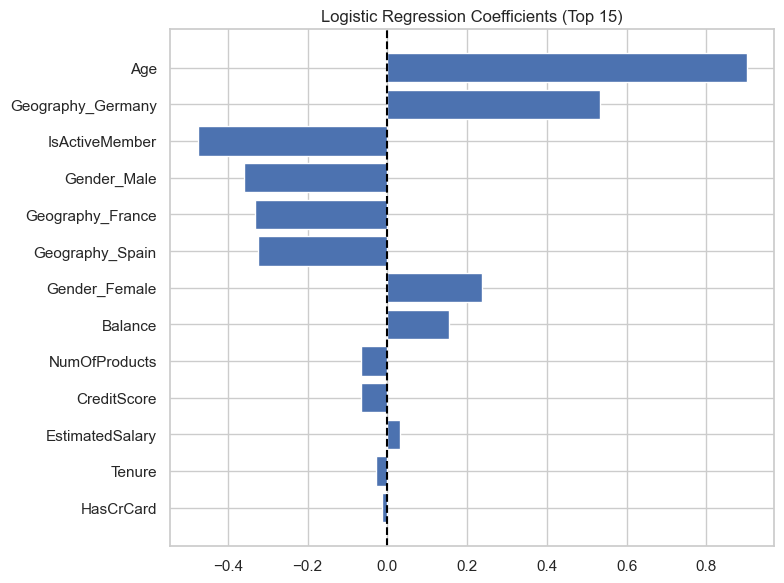

In [139]:
plt.figure(figsize=(8,6))
plt.barh(fi_lr.head(15)["feature"][::-1], fi_lr.head(15)["coef"][::-1])
plt.title("Logistic Regression Coefficients (Top 15)")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.show()


In [140]:
# Holdout split just for reporting
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2,
                                          stratify=y, random_state=42)

hold_lr = lr_pipe.fit(X_tr, y_tr)
lr_probs = hold_lr.predict_proba(X_te)[:,1]
lr_pred  = (lr_probs >= 0.50).astype(int)

compare_lr = X_te.copy()
compare_lr["Actual"] = y_te.values
compare_lr["LR_Prob"] = lr_probs
compare_lr["LR_Pred"] = lr_pred

# Filter churners
churn_view_lr = compare_lr[compare_lr["Actual"]==1].sort_values("LR_Prob", ascending=False)
display(churn_view_lr.head(25))


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Actual,LR_Prob,LR_Pred
7008,635,Germany,Female,65,5,117325.54,1,1,0,155799.86,1,0.971749,1
2473,351,Germany,Female,57,4,163146.46,1,1,0,169621.69,1,0.961937,1
416,487,Germany,Female,61,5,110368.03,1,0,0,11384.45,1,0.961139,1
7851,758,Germany,Male,68,6,112595.85,1,1,0,35865.44,1,0.952657,1
7636,517,Germany,Female,59,8,154110.99,2,1,0,101240.08,1,0.950656,1
776,622,Germany,Female,58,7,116922.25,1,1,0,120415.61,1,0.949093,1
3991,496,Germany,Female,59,7,91680.10,2,1,0,163141.18,1,0.947925,1
399,616,France,Female,66,1,135842.41,1,1,0,183840.51,1,0.942077,1
2168,705,Germany,Female,56,2,143249.67,1,1,0,88428.41,1,0.939470,1
2350,617,Germany,Female,58,3,119024.75,2,1,0,35199.24,1,0.934898,1


# final stage

In [141]:
# --- BN Results (from Stage 2) ---
# suppose best_metrics_bn was computed already
bn_results = {
    "Model": "BN (Balanced)",
    "CA": best_metrics_bn["CA"],
    "Precision": best_metrics_bn["Precision"],
    "Recall": best_metrics_bn["Recall"],
    "F1": best_metrics_bn["F1"],
    "AUC": best_metrics_bn["AUC"],
    "Type I Error": best_metrics_bn["Type I Error"],
    "Type II Error": best_metrics_bn["Type II Error"],
    "Threshold": best_metrics_bn["Threshold"]
}

# --- RF Results (mean CV scores) ---
rf_results = {
    "Model": "Random Forest (CV)",
    "CA": summary_rf.loc["Accuracy","Mean"],
    "Precision": summary_rf.loc["Precision","Mean"],
    "Recall": summary_rf.loc["Recall","Mean"],
    "F1": summary_rf.loc["F1","Mean"],
    "AUC": summary_rf.loc["AUC","Mean"],
    "Type I Error": summary_rf.loc["Type I Error","Mean"],
    "Type II Error": summary_rf.loc["Type II Error","Mean"],
    "Threshold": 0.50   # or tuned threshold if you want
}

# --- LR Results (mean CV scores) ---
lr_results = {
    "Model": "Logistic Regression (CV)",
    "CA": summary_lr.loc["Accuracy","Mean"],
    "Precision": summary_lr.loc["Precision","Mean"],
    "Recall": summary_lr.loc["Recall","Mean"],
    "F1": summary_lr.loc["F1","Mean"],
    "AUC": summary_lr.loc["AUC","Mean"],
    "Type I Error": summary_lr.loc["Type I Error","Mean"],
    "Type II Error": summary_lr.loc["Type II Error","Mean"],
    "Threshold": 0.50
}

# --- Build final DataFrame ---
compare_all = pd.DataFrame([bn_results, rf_results, lr_results])
display(compare_all.round(4))


,Model,CA,Precision,Recall,F1,AUC,Type I Error,Type II Error,Threshold
0,BN (Balanced),0.7453,0.7065,0.8391,0.7671,0.8277,0.3486,0.1609,0.4
1,Random Forest (CV),0.8230,0.5534,0.6839,0.6115,0.8581,0.1414,0.3161,0.5
2,Logistic Regression (CV),0.7164,0.3895,0.6917,0.4983,0.7689,0.2773,0.3083,0.5


In [142]:
# --------------------------
# Stage 5: Final Comparison
# --------------------------

# --- (A) BN Results (already computed in Stage 2) ---
bn_results = {
    "Model": "BN (Balanced)",
    "CA": best_metrics_bn["CA"],
    "Precision": best_metrics_bn["Precision"],
    "Recall": best_metrics_bn["Recall"],
    "F1": best_metrics_bn["F1"],
    "AUC": best_metrics_bn["AUC"],
    "Type I Error": best_metrics_bn["Type I Error"],
    "Type II Error": best_metrics_bn["Type II Error"],
    "Threshold": best_metrics_bn["Threshold"]
}

# --- (B) Random Forest Results (CV summary) ---
rf_results = {
    "Model": "Random Forest (CV)",
    "CA": summary_rf.loc["Accuracy","Mean"],
    "Precision": summary_rf.loc["Precision","Mean"],
    "Recall": summary_rf.loc["Recall","Mean"],
    "F1": summary_rf.loc["F1","Mean"],
    "AUC": summary_rf.loc["AUC","Mean"],
    "Type I Error": summary_rf.loc["Type I Error","Mean"],
    "Type II Error": summary_rf.loc["Type II Error","Mean"],
    "Threshold": 0.50
}

# --- (C) Logistic Regression Results (CV summary) ---
lr_results = {
    "Model": "Logistic Regression (CV)",
    "CA": summary_lr.loc["Accuracy","Mean"],
    "Precision": summary_lr.loc["Precision","Mean"],
    "Recall": summary_lr.loc["Recall","Mean"],
    "F1": summary_lr.loc["F1","Mean"],
    "AUC": summary_lr.loc["AUC","Mean"],
    "Type I Error": summary_lr.loc["Type I Error","Mean"],
    "Type II Error": summary_lr.loc["Type II Error","Mean"],
    "Threshold": 0.50
}

# --- (D) Combine into Final Comparison Table ---
final_comparison = pd.DataFrame([bn_results, rf_results, lr_results])
display(final_comparison.round(4))


# --------------------------
# Stage 5B: Prediction Comparison
# --------------------------

# Split train-test again for actual prediction check
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

# --- Train RF and LR final models ---
rf_final = rf_pipe.fit(X_train, y_train)
lr_final = lr_pipe.fit(X_train, y_train)

# --- Predictions ---
rf_probs = rf_final.predict_proba(X_test)[:,1]
lr_probs = lr_final.predict_proba(X_test)[:,1]

rf_preds = (rf_probs >= 0.50).astype(int)
lr_preds = (lr_probs >= 0.50).astype(int)

# --- Actual vs Predicted Comparison ---
compare_preds = pd.DataFrame({
    "Actual": y_test.values,
    "RF_Pred": rf_preds,
    "LR_Pred": lr_preds
}).reset_index(drop=True)

print("Sample comparison of Actual vs Predicted (first 20 rows):")
display(compare_preds.head(20))

# --- Optional: Confusion Matrices ---
print("\nConfusion Matrix - Random Forest")
print(confusion_matrix(y_test, rf_preds))

print("\nConfusion Matrix - Logistic Regression")
print(confusion_matrix(y_test, lr_preds))


,Model,CA,Precision,Recall,F1,AUC,Type I Error,Type II Error,Threshold
0,BN (Balanced),0.7453,0.7065,0.8391,0.7671,0.8277,0.3486,0.1609,0.4
1,Random Forest (CV),0.8230,0.5534,0.6839,0.6115,0.8581,0.1414,0.3161,0.5
2,Logistic Regression (CV),0.7164,0.3895,0.6917,0.4983,0.7689,0.2773,0.3083,0.5


Sample comparison of Actual vs Predicted (first 20 rows):


,Actual,RF_Pred,LR_Pred
0,0,0,0
1,0,0,1
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,1
8,0,1,1
9,0,0,0



Confusion Matrix - Random Forest
[[1354  239]
 [ 120  287]]

Confusion Matrix - Logistic Regression
[[1152  441]
 [ 124  283]]


In [144]:
# --- Show probability table for first 10 rows ---
bn_preds = []
bn_nodes = set(bn.nodes())

for _, row in bn_df.head(10).iterrows():
    evidence = {}
    for k, v in row.drop("Exited").to_dict().items():
        if k in bn_nodes:
            # If the BN CPD states are numbers, keep as int
            try:
                # check if BN has numeric states
                states = bn.get_cpds(k).state_names[k]
                if all(isinstance(s, (int, np.integer)) for s in states):
                    evidence[k] = int(v)
                else:
                    evidence[k] = str(v)
            except Exception:
                evidence[k] = v

    q = infer.query(variables=["Exited"], evidence=evidence)

    bn_preds.append({
        "Actual": row["Exited"],
        "P(Exited=0)": f"{q.values[0]*100:.2f}%",
        "P(Exited=1)": f"{q.values[1]*100:.2f}%",
        "Predicted": 1 if q.values[1] >= best_metrics_bn["Threshold"] else 0
    })

bn_pred_df = pd.DataFrame(bn_preds)
print(bn_pred_df)


   Actual P(Exited=0) P(Exited=1)  Predicted
0       1      55.91%      44.09%          1
1       0      49.58%      50.42%          1
2       1       3.14%      96.86%          1
3       0      62.01%      37.99%          0
4       0      62.86%      37.14%          0
5       1      86.74%      13.26%          0
6       0      95.21%       4.79%          0
7       1       0.00%     100.00%          1
8       0      92.02%       7.98%          0
9       0      76.00%      24.00%          0


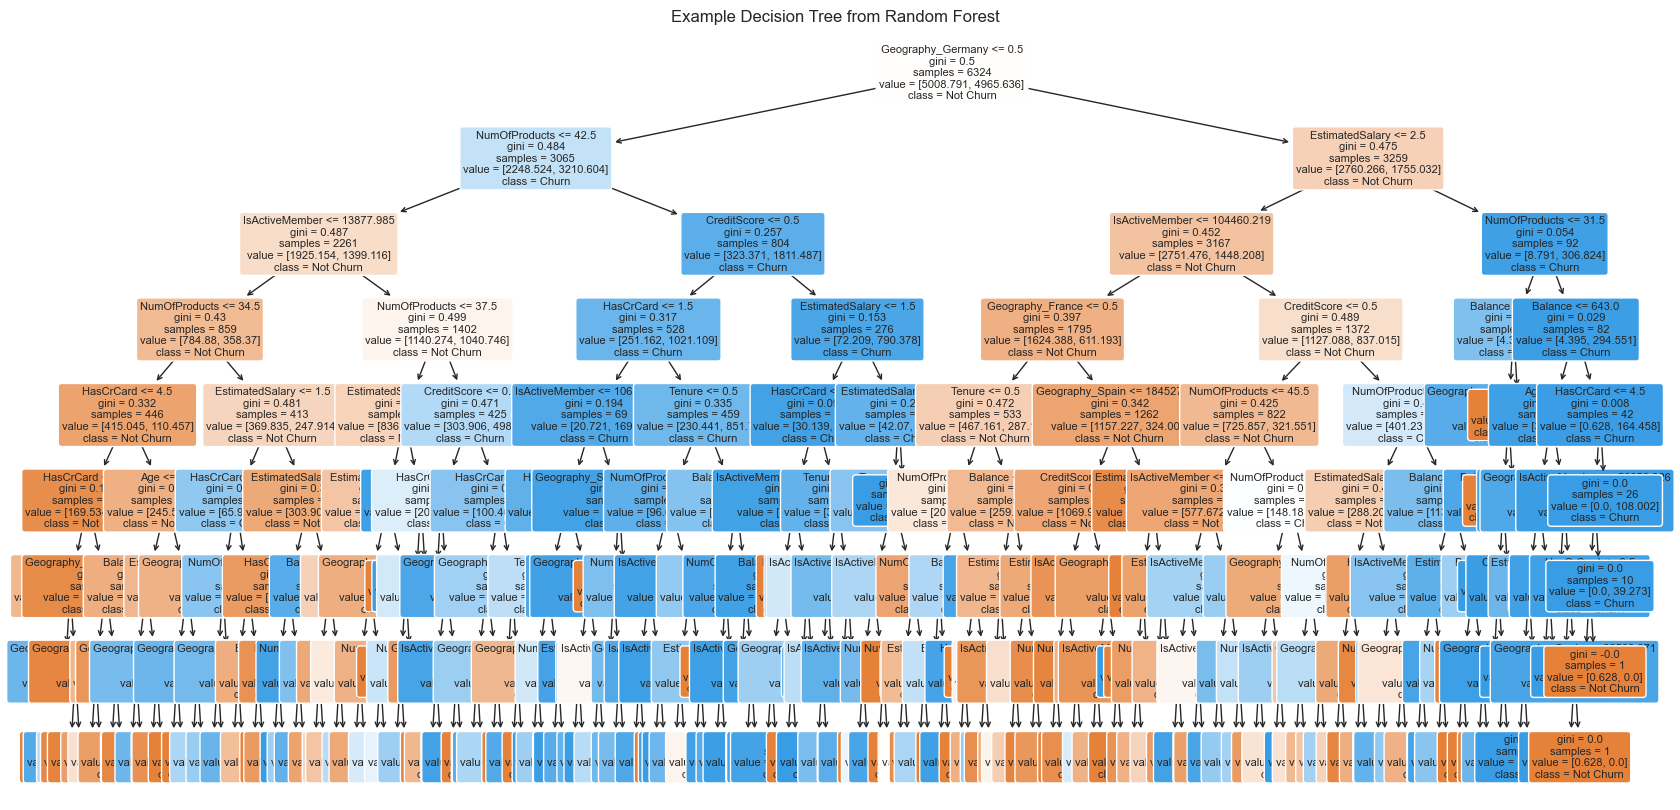

In [147]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Take one tree from the fitted Random Forest
estimator = final_rf.named_steps["rf"].estimators_[0]   # pick the first tree

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(
    estimator,
    feature_names=feat_names,
    class_names=["Not Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Example Decision Tree from Random Forest")
plt.show()


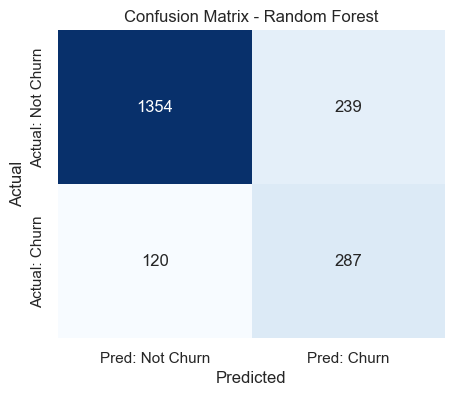

Random Forest Confusion Matrix:
 [[1354  239]
 [ 120  287]]


In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Random Forest Confusion Matrix ---
y_rf_pred = rf_final.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred: Not Churn", "Pred: Churn"],
            yticklabels=["Actual: Not Churn", "Actual: Churn"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print("Random Forest Confusion Matrix:\n", cm_rf)


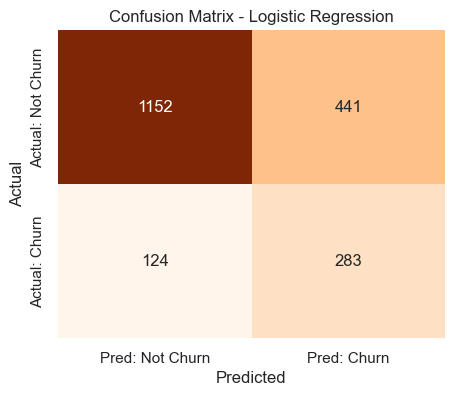

Logistic Regression Confusion Matrix:
 [[1152  441]
 [ 124  283]]


In [153]:
# --- Logistic Regression Confusion Matrix ---
y_lr_pred = lr_final.predict(X_test)
cm_lr = confusion_matrix(y_test, y_lr_pred, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=["Pred: Not Churn", "Pred: Churn"],
            yticklabels=["Actual: Not Churn", "Actual: Churn"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print("Logistic Regression Confusion Matrix:\n", cm_lr)


In [157]:
# Fit the final model
lr_pipe.fit(X, y)

# Get coefficients
coefs = lr_pipe.named_steps["lr"].coef_[0]
intercept = lr_pipe.named_steps["lr"].intercept_[0]

# Get feature names from preprocessing
prep = lr_pipe.named_steps["prep"]
num_names = numeric_cols
cat_names = prep.named_transformers_["cat"].get_feature_names_out(categorical_cols).tolist()
feat_names = num_names + cat_names

# Combine into equation form
equation = f"Logit(P(Exited=1)) = {intercept:.4f}"
for name, coef in zip(feat_names, coefs):
    equation += f" + ({coef:.4f} * {name})"

print(equation)


Logit(P(Exited=1)) = -0.1234 + (-0.0667 * CreditScore) + (0.9006 * Age) + (-0.0281 * Tenure) + (0.1537 * Balance) + (-0.0669 * NumOfProducts) + (-0.0143 * HasCrCard) + (-0.4759 * IsActiveMember) + (0.0307 * EstimatedSalary) + (-0.3320 * Geography_France) + (0.5328 * Geography_Germany) + (-0.3242 * Geography_Spain) + (0.2362 * Gender_Female) + (-0.3597 * Gender_Male)


In [159]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

# After you have predictions
y_pred = model.predict(X_test)

# Option 1: classification report (easy)
print(classification_report(y_test, y_pred, target_names=["Not Churn (0)", "Churn (1)"]))

# Option 2: precision/recall separately
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=[0,1])

print("Class 0 (Not Churn):")
print(f"  Precision: {prec[0]:.4f}")
print(f"  Recall   : {rec[0]:.4f}")

print("Class 1 (Churn):")
print(f"  Precision: {prec[1]:.4f}")
print(f"  Recall   : {rec[1]:.4f}")


               precision    recall  f1-score   support

Not Churn (0)       0.90      0.72      0.80      1593
    Churn (1)       0.39      0.70      0.50       407

     accuracy                           0.72      2000
    macro avg       0.65      0.71      0.65      2000
 weighted avg       0.80      0.72      0.74      2000

Class 0 (Not Churn):
  Precision: 0.9042
  Recall   : 0.7232
Class 1 (Churn):
  Precision: 0.3926
  Recall   : 0.7002


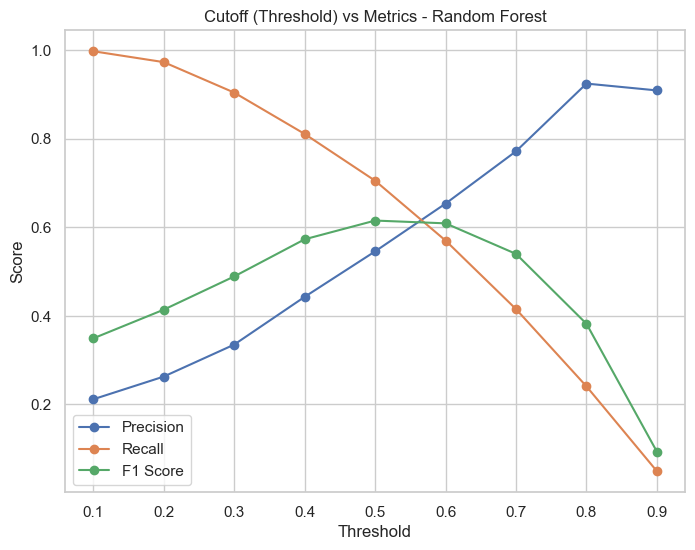

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 1.0, 0.1)
precisions, recalls, f1s = [], [], []

proba_rf = rf_final.predict_proba(X_test)[:,1]

for t in thresholds:
    preds = (proba_rf >= t).astype(int)
    precisions.append(precision_score(y_test, preds))
    recalls.append(recall_score(y_test, preds))
    f1s.append(f1_score(y_test, preds))

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker="o", label="Precision")
plt.plot(thresholds, recalls, marker="o", label="Recall")
plt.plot(thresholds, f1s, marker="o", label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Cutoff (Threshold) vs Metrics - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


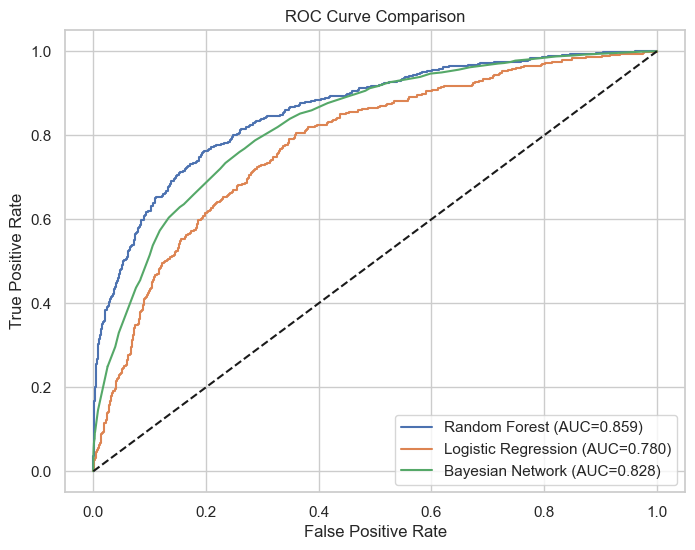

In [175]:
from sklearn.metrics import roc_curve, roc_auc_score

# RF
proba_rf = rf_final.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
auc_rf = roc_auc_score(y_test, proba_rf)

# LR
proba_lr = lr_final.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
auc_lr = roc_auc_score(y_test, proba_lr)

# BN (probabilities already computed in evaluate_bn)
proba_bn = y_proba   # from BN inference
fpr_bn, tpr_bn, _ = roc_curve(y_true, proba_bn)
auc_bn = roc_auc_score(y_true, proba_bn)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_bn, tpr_bn, label=f"Bayesian Network (AUC={auc_bn:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


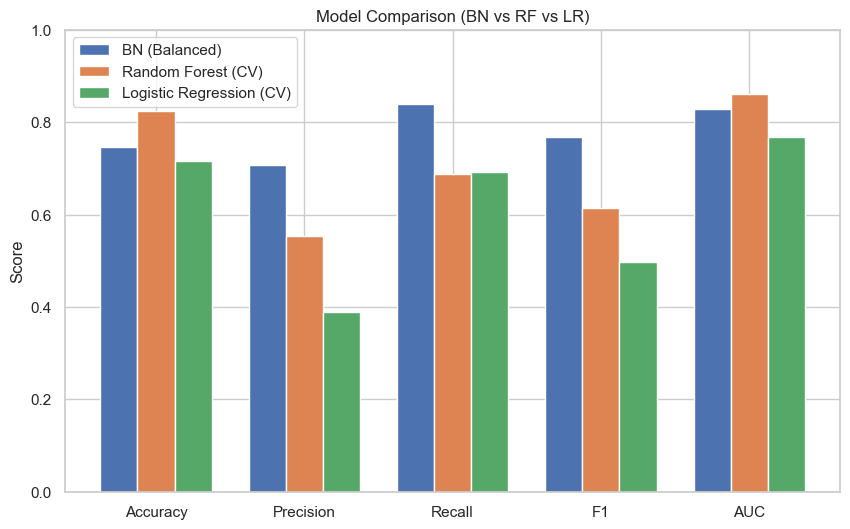

In [176]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Your final model comparison results ---
comparison_data = {
    "Model": ["BN (Balanced)", "Random Forest (CV)", "Logistic Regression (CV)"],
    "Accuracy": [0.7453, 0.8238, 0.7164],
    "Precision": [0.7065, 0.5545, 0.3895],
    "Recall": [0.8391, 0.6888, 0.6917],
    "F1": [0.7671, 0.6143, 0.4983],
    "AUC": [0.8277, 0.8616, 0.7689]
}

df_compare = pd.DataFrame(comparison_data)

# --- Plot grouped bar chart ---
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
x = range(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))

plt.bar([p - width for p in x], df_compare.loc[0, metrics], width, label="BN (Balanced)")
plt.bar(x, df_compare.loc[1, metrics], width, label="Random Forest (CV)")
plt.bar([p + width for p in x], df_compare.loc[2, metrics], width, label="Logistic Regression (CV)")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Model Comparison (BN vs RF vs LR)")
plt.legend()
plt.show()
